# VIRTUAL CASH MANAGER v1

El objetivo es obtener una previsión de flujo de caja para los próximos días para lo cual partimos de dos tipos de datos: ciertos e inciertos. Los datos ciertos son aquellas transacciones con fecha de vencimiento futura conocida. Los datos inciertos son todas aquellas transacciones históricas registradas que no tienen fecha de vencimiento.  

Una vez separados los datos procedemos a hacer un **scheduling** para los datos ciertos y un **forecasting** para los datos inciertos. El scheduling consiste en una agregar flujos de caja por fecha de vencimiento futura y por cuenta. El forecasting utilizaremos alguna técnica de forecasting sencilla que de mejores resultados.

In [102]:
#Importamos los móduglos necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.optimize as sco
from datetime import datetime, timedelta, date
%matplotlib inline

# **1. Scheduling** 

Para el scheduling utilizamos datos de transacciones registradas con fecha de vencimiento desde hoy en adelante (por ejemplo facturas de clientes y proveedores). Se trata de compromisos ciertos de cobro y de pago.

In [103]:
data = pd.read_csv("SampleMovs2.csv",delimiter=";")
data.index = pd.to_datetime(data.DueDate)
print(len(data))
data.head()

121


,TransDate,DueDate,Cuenta,Importe,Empresa,Tipo
DueDate,,,,,,
2016-12-10,14/07/2016,12/10/2016,banco03,-25.37,emp01,Cierto
2016-10-13,15/07/2016,13/10/2016,banco03,395.91,emp01,Cierto
2016-10-15,17/07/2016,15/10/2016,banco03,199.56,emp01,Cierto
2016-10-17,19/07/2016,17/10/2016,banco03,-3.85,emp01,Cierto
2016-10-25,27/07/2016,25/10/2016,banco03,216.23,emp01,Cierto


In [104]:
now = datetime.now()
now

datetime.datetime(2016, 9, 28, 16, 2, 58, 580828)

Scheduling para los próximos días según vencimiento y partiendo de un saldo inicial. Lista de cuentas y saldos iniciales:

In [105]:
cuentas = ['banco01','banco02','banco03']
inicial = [1000,2000,3000]

Calculamos los saldos diarios a partir del saldo inicial

In [106]:
sched = []
now = datetime.now()
#d = timedelta(n)
for elem in cuentas:
    df = data[data.Cuenta==elem]
    df = df.resample('D') #Resample considera todas las fechas posibles, no solo aquellas en las que hay un flujo de caja
    n = len(df[now:])
    L = np.tril(np.ones((n,n)))
    flow = np.array(df[now:].Importe.values).reshape((n,1))
    flow = np.nan_to_num(flow)
    i = 0
    bal = inicial[i] + np.dot(L,flow)
    i += 1
    sched.append(bal)

In [107]:
from pylab import *

Y los representamos gráficamente

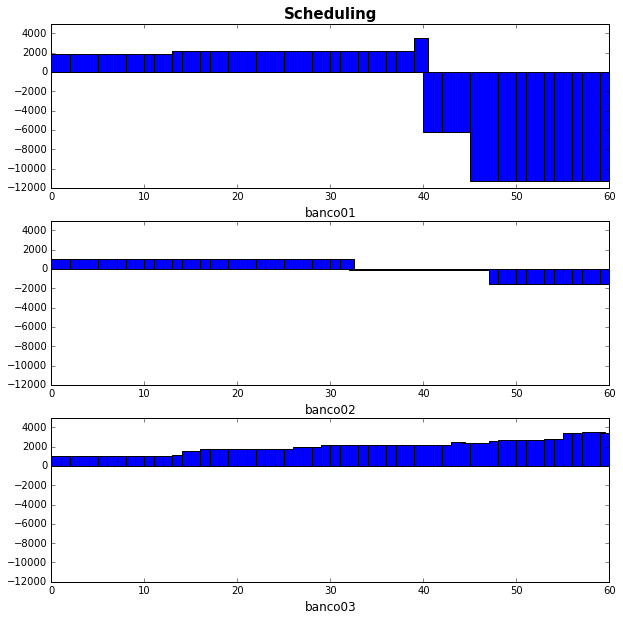

In [128]:
p = 60
ylim = [-12000,5000]
number_of_subplots = 3
figure(figsize=(10,10))
for v in range(len(cuentas)):
    v = v+1
    ax1 = subplot(number_of_subplots,1,v)
    ax1.bar(range(p),sched[v-1][0:p],width=1.5)
    ax1.set_xlabel(str(cuentas[v-1]),fontsize=12)
    ax1.set_xlim([0, p])
    ax1.set_ylim(ylim)

ax1 = subplot(number_of_subplots,1,1)
ax1.set_title('Scheduling',fontsize=15,fontweight='bold')
plt.show()

Con estos gráficos el usuario ya sabe cuándo está previsto que una cuenta se quede en negativo. Antes de que llegue la fecha habrá que hacer algún movimiento de compensación entre cuentas

# **Forecasting**

Para el forecasting asumimos que disponemos de un histórico de movimientos "inciertos". Es decir, todos los movimientos ciertos con fecha de vencimiento se han eliminado del histórico.


1) Primero conviene hacer un pequeño estudio estadístico de las carácteristicas del flujo de caja para conocer la volatilidad, estacionalidad y eliminar outliers.

2) Luego, aplicamos alguna técnica de forecasting. De los 3 modelos probados el que mejor funciona en el ejemplo es el de estacionalidad Día-Semana y Día-Mes


In [109]:
data2 = pd.read_csv("movimientos.csv",delimiter=",")
data2.head()

,Empresa,Fecha,Debe,Haber,Subcuenta
0,1,01/01/13 00:00,0.00,2386.56,572010003
1,1,31/07/13 00:00,82991.04,0.00,572010003
2,1,31/07/13 00:00,0.00,83961.93,572010003
3,1,01/08/13 00:00,2863.00,0.00,572010003
4,1,01/08/13 00:00,5500.00,0.00,572010003


In [110]:
data3 = pd.DataFrame(data2[data2.Empresa == 48]) #Seleccionamos una empresa como ejemplo
data3.index = pd.to_datetime(data3.Fecha)
data3.head()

,Empresa,Fecha,Debe,Haber,Subcuenta
Fecha,,,,,
2014-01-01,48,01/01/14 00:00,261.07,0.00,57200001
2014-12-31,48,31/12/14 00:00,0.00,261.07,57200001
2014-01-01,48,01/01/14 00:00,41477.77,0.00,57200003
2014-02-01,48,02/01/14 00:00,0.00,37.60,57200003
2014-03-01,48,03/01/14 00:00,0.00,600.00,57200003


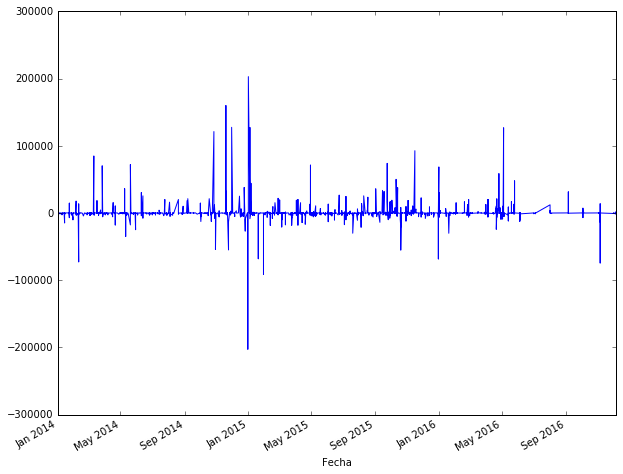

In [130]:
data3['NetCF'] = data3.Debe - data3.Haber
data3.NetCF.plot(figsize=(10, 8))

In [112]:
data3.NetCF.describe()

count      2580.000000
mean        125.723837
std       11089.322145
min     -202806.080000
25%        -942.900000
50%        -202.540000
75%         -37.745000
max      202806.080000
Name: NetCF, dtype: float64

In [113]:
data3.NetCF[abs(data3.NetCF) > 3*data3.NetCF.std()] #Todos estos pueden considerarse valores anómalos

Fecha
2014-01-01     41477.77
2014-03-27     70180.00
2014-05-20     71995.00
2014-05-09     36000.00
2014-02-10    -73032.88
2014-10-27    121060.50
2014-10-30    -54326.25
2014-03-11     84775.62
2014-05-11    -35101.69
2014-11-19    159720.00
2014-11-24    -55110.38
2014-11-30    127382.75
2014-12-24     37933.50
2014-12-31   -202806.08
2015-01-01    202806.08
2015-01-20    -68186.11
2015-01-30    -91520.17
2015-09-02     35993.70
2015-01-04     36300.00
2015-01-04     54450.00
2015-01-04    127050.00
2015-04-30     71087.50
2015-01-06     43983.50
2015-09-15     33517.00
2015-09-24     73689.00
2015-10-14     37631.00
2015-10-20    -55403.75
2015-10-11     50000.00
2015-11-16     92565.00
2015-12-31    -68439.31
2016-01-01     68439.31
2016-05-04    126750.00
2016-04-25     58382.50
2016-11-05    -74500.00
2016-05-25     47674.00
Name: NetCF, dtype: float64

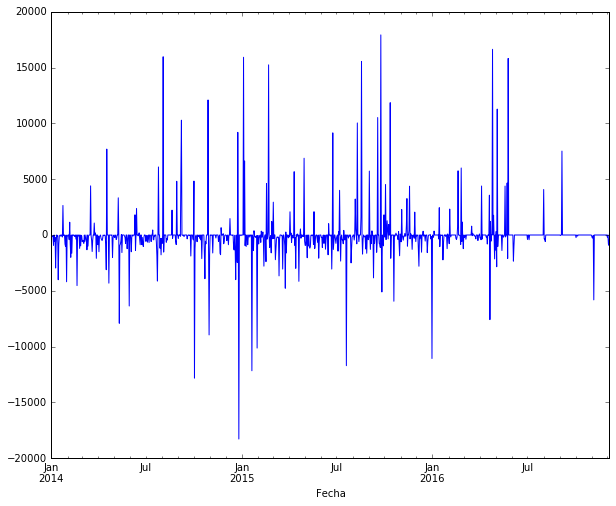

In [114]:
NetCF = pd.Series(data3.NetCF).resample('D').fillna(0) #Agrupamos por fecha y añadimos fechas con flujo de caja cero
NetCF[abs(NetCF) > 3*np.std(NetCF)] = 0  #Anulamos outliers sustituyendo por la media
NetCF.plot(figsize=(10, 8))

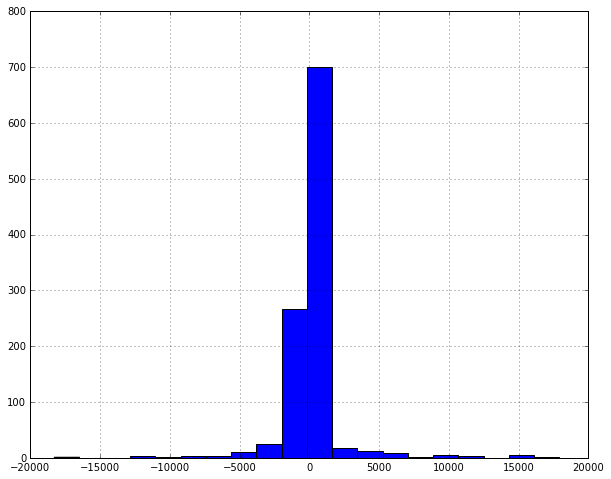

In [115]:
data4.NetCF.hist(figsize=(10, 8),bins=20)

**Modelo 1. Modelo estacional día-semana + día-mes**

In [116]:
data4 = pd.DataFrame(NetCF)
data4['Weekday'] = data4.index.weekday+1
data4['DayMonth'] = data4.index.day
data4['DOM-DOW']=[(int(data4.ix[t].Weekday), int(data4.ix[t].DayMonth)) for t in range(len(data4))]
data4.head(10)

,NetCF,Weekday,DayMonth,DOM-DOW
Fecha,,,,
2014-01-01,0.000000,3,1,"(3, 1)"
2014-01-02,-138.500000,4,2,"(4, 2)"
2014-01-03,-105.475000,5,3,"(5, 3)"
2014-01-04,-94.385000,6,4,"(6, 4)"
2014-01-05,-919.745000,7,5,"(7, 5)"
2014-01-06,0.000000,1,6,"(1, 6)"
2014-01-07,-561.336667,2,7,"(2, 7)"
2014-01-08,-207.800000,3,8,"(3, 8)"
2014-01-09,-2960.000000,4,9,"(4, 9)"


In [117]:
estim = data4.groupby(['DOM-DOW']).NetCF.mean()
fcast = estim[data4['DOM-DOW']]
data4['season'] = fcast.values

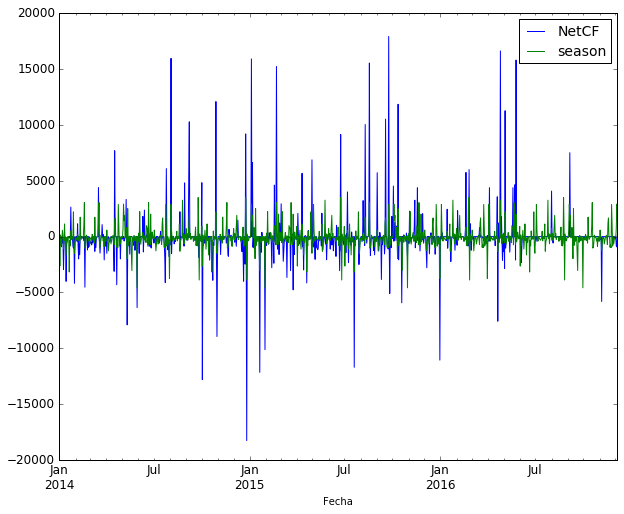

In [118]:
data4[['NetCF', 'season']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

In [119]:
rmse_season = ((data4.season-data4.NetCF)**2).sum()/((data4.NetCF.mean()-data4.NetCF)**2).sum()
rmse_season  #Este es el modelo que mejor funciona

0.7957969752812916

In [120]:
estim[dia_pred] #Para un día en concreto

21.971249999999991

In [121]:
nextdates = pd.date_range(now,periods=20)
nextdays = [((nextdates.dayofweek+1)[i],nextdates.day[i]) for i in range(len(nextdates))] 

In [122]:
estim[nextdays] #Para los próximos 20 días

DOM-DOW
(3, 28)      21.971250
(4, 29)    -185.532500
(5, 30)   -4588.631125
(6, 1)     -151.970667
(7, 2)     -141.776000
(1, 3)     -112.510867
(2, 4)     -322.856667
(3, 5)      208.745500
(4, 6)       44.044155
(5, 7)     -348.963333
(6, 8)        0.000000
(7, 9)     -585.512750
(1, 10)    1743.638167
(2, 11)      -0.404000
(3, 12)    -254.817733
(4, 13)    -132.762000
(5, 14)     -25.600000
(6, 15)     -20.000000
(7, 16)       0.000000
(1, 17)    1017.853500
Name: NetCF, dtype: float64

** Modelo 2. Media móvil**

In [123]:
import statsmodels.api as sm 

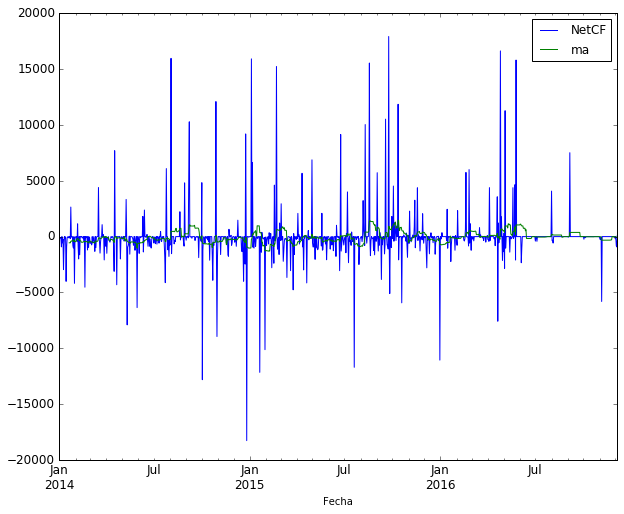

In [124]:
ma = pd.rolling_mean(data4['NetCF'], 20) #Aplicando una media móvil
data4['ma'] = ma
plot = data4[['NetCF', 'ma']].plot(figsize=(10, 8), fontsize=12)

In [125]:
rmse_ma = ((data4.ma-data4.NetCF)**2).sum()/((data4.NetCF.mean()-data4.NetCF)**2).sum()
rmse_ma

0.9456573805282852

** Modelo 3. ARIMA **

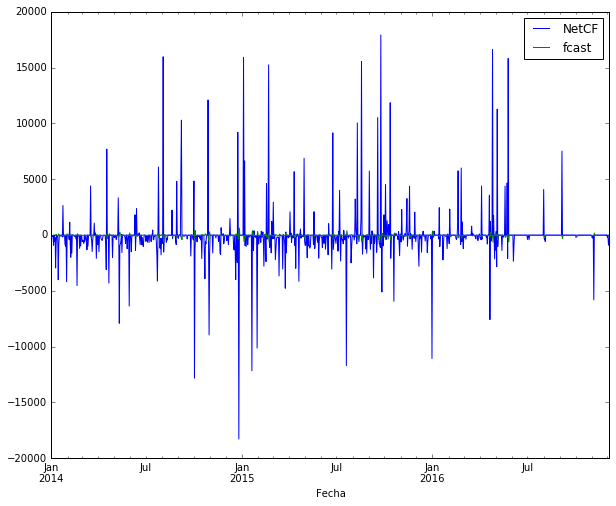

In [126]:
model = sm.tsa.ARIMA(data4['NetCF'].iloc[1:], order=(1, 0, 0))  #Modelo AR
res = model.fit(disp=-1)  
data4['fcast'] = res.fittedvalues  
plot = data4[['NetCF', 'fcast']].plot(figsize=(10, 8)) 

In [127]:
rmse_arima = ((data4.fcast-data4.NetCF)**2).sum()/((data4.NetCF.mean()-data4.NetCF)**2).sum()
rmse_arima  #Un valor por encima de 1 es un resultado peor que la media, la mejor predicción es el valor medio que es cero

0.9986761623107829

De los tres modelos el que mejor funciona es el de estacionalidad DOM-DOW.  

Finalmente habría que sumar por día, la previsión por scheduling y la previsión por forecasting.